# https://distill.pub/2020/growing-ca/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import random
import requests
import io

%matplotlib inline

In [2]:
torch.__version__

'1.4.0'

In [3]:
device='cuda:0'

In [4]:
class Perception(nn.Module):
    def __init__(self, learnable=False):
        super().__init__()
        sobel_x = (torch.tensor([[-1, 0, +1],
                                [-2, 0, +2],
                                [-1, 0, +1]]).float() / 8)[None, None, ...].repeat(16, 16, 1, 1)
        sobel_y = (torch.tensor([[-1, -2, -1],
                                [0, 0, 0],
                                [-1, -2, -1]]).float() / 8)[None, None, ...].repeat(16, 16, 1, 1)
        idt = (torch.tensor([[0, 0, 0],
                            [0, 1, 0],
                            [0, 0, 0]]).float())[None, None, ...].repeat(16, 16, 1, 1)
        if learnable:
            self.sobel_x = nn.Parameter(sobel_x, requires_grad=True)
            self.sobel_y = nn.Parameter(sobel_y, requires_grad=True)
            self.identity = nn.Parameter(idt, requires_grad=True)

        else:
            self.sobel_x = nn.Parameter(sobel_x, requires_grad=False)
            self.sobel_y = nn.Parameter(sobel_y, requires_grad=False)
            self.identity = nn.Parameter(idt, requires_grad=False)


    def forward(self, state_grid):
        grad_x = F.conv2d(state_grid, self.sobel_x, padding=1)
        grad_y = F.conv2d(state_grid, self.sobel_y, padding=1)
        idt = F.conv2d(state_grid, self.identity, padding=1)
        perception_grid = torch.cat([idt, grad_x, grad_y],  dim=1)
        return perception_grid

class Policy(nn.Module):
    def __init__(self, state_dim=16, interm_dim=128, use_embedding=True):
        super().__init__()
        dim = state_dim * 3
        if use_embedding:
            dim += 1
        self.conv1 = nn.Conv2d(dim, interm_dim, 1)
        self.conv2 = nn.Conv2d(interm_dim, state_dim, 1)
        nn.init.constant_(self.conv2.weight, 0.)
        nn.init.constant_(self.conv2.bias, 0.)
        
    def forward(self, state):
        interm = self.conv1(state)
        interm = nn.LeakyReLU()(interm)
        return self.conv2(interm)
    

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedder = nn.Sequential(*[nn.Conv2d(4, 16, 3),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 16, 3),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 1, 3)])
    
    def forward(self, img):
        return nn.AdaptiveAvgPool2d((1, 1))(self.embedder(img))
    

def stochastic_update_mask(ds_grid, prob=0.5):
    # Generate mask for zero out a random fraction of the updates.
    bern = torch.distributions.Bernoulli(prob)
    rand_mask = bern.sample_n(ds_grid.shape[2] * ds_grid.shape[3]).view(ds_grid.shape[2:]).float().to(ds_grid.device)
    return rand_mask

def alive_mask(state_grid, thr=0.1):
    # Take the alpha channel as the measure of “life”.
    alive = (state_grid[:, 4, :, :].clamp(0, 1) > thr).float().unsqueeze(1)#.repeat(1, 16, 1, 1)
    return alive


In [5]:
def load_image(url, max_size=128):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img) / 255.
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
    return load_image(url)



tensor(1., device='cuda:0') tensor(-1., device='cuda:0') tensor(-0.6186, device='cuda:0')


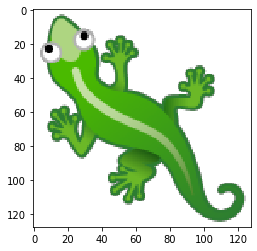

In [6]:
target = load_emoji(emoji='🦎')
target = torchvision.transforms.ToTensor()(target)
target = torchvision.transforms.Normalize(tuple(0.5 for _ in range(target.shape[0])),
                                          tuple(0.5 for _ in range(target.shape[0])))(target)
target = target.unsqueeze(0).to(device)
print(target.max(), target.min(), target.mean())
plt.imshow((target[0].cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [7]:
state_grid = torch.zeros((1, 16, 128, 128), requires_grad=False, device=device)
state_grid[0, :, random.randint(14, 18), random.randint(14, 18)] += 1.
alive_mask(state_grid).shape

torch.Size([1, 1, 128, 128])

In [366]:
policy = Policy(use_embedding=False).to(device)
perception = Perception(learnable=False).to(device)
#embedder = Embedder().to(device)
optim = torch.optim.Adam(list(policy.parameters()), lr=2e-4)
loss_fn = nn.MSELoss()

In [367]:
target.shape

torch.Size([1, 4, 128, 128])

0.2974504828453064
0.2773623466491699
0.24098679423332214
0.2507267892360687
0.25940150022506714
0.20949511229991913
0.22598473727703094
0.32536575198173523
0.2138049453496933
0.20744548738002777
0.20816223323345184
0.21265815198421478
0.20908281207084656
0.21125714480876923
0.21758687496185303
0.2597072422504425
0.21088284254074097
0.3496813476085663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2522745728492737
0.2090931534767151


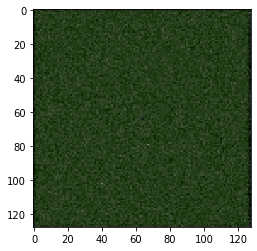

In [378]:
for step in range(20):
    optim.zero_grad()
    state_grid = torch.zeros((1, 16, 128, 128), requires_grad=False, device=device)
    center = state_grid.shape[2] // 2
    state_grid[0, 4:, center, center] += torch.randn_like(state_grid[0, 4:, 16, 16])
    state_grid[0, 4, center, center] = torch.ones_like(state_grid[0, 4, 16, 16])
    
    imgs = []
    #embedding = embedder(target)
    for k in range(random.randint(40, 80)):
        alive_pre = alive_mask(state_grid)
        perception_grid = perception(state_grid)
        #perception_grid = torch.cat([perception_grid, embedding.repeat(1, 1, 128, 128)], dim=1)
        ds_grid = policy(perception_grid)
        mask = stochastic_update_mask(ds_grid, prob=0.5)[None, None]
        state_grid = state_grid + ds_grid * mask
    alive_post = alive_mask(state_grid, thr=0.1)
    state_grid = state_grid * alive_post
    loss_value = loss_fn(target[:, :3, ...], state_grid[:, :3, ...])
    loss_value.backward()
    optim.step()
    print(loss_value.item())
plt.imshow(((state_grid[0, :3, ...]).cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


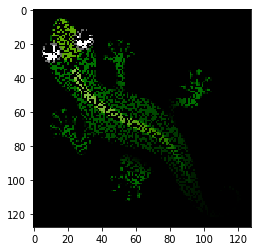

In [200]:
plt.imshow((target * mask)[0].permute(1, 2, 0)[:, :, :3].cpu().data.numpy())

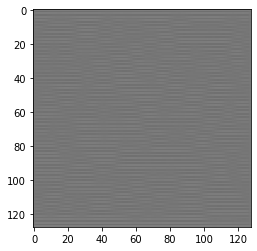

In [181]:
plt.imshow((perception_grid[0, 32:35].permute(1, 2, 0).cpu().data.numpy() + 1) / 2)

In [182]:
(torch.ones_like(state_grid) * (1 - alive_post)).shape

torch.Size([1, 16, 128, 128])

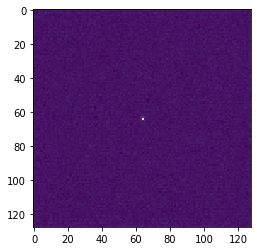

In [183]:
plt.imshow(state_grid[0, 4, ...].cpu().data.numpy())

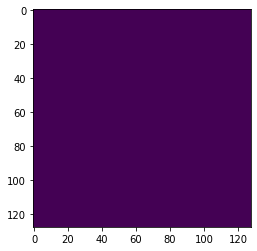

In [184]:
plt.imshow(alive_mask(state_grid, thr=0.1).cpu().data.numpy()[0][0])

In [185]:
alive_post.sum()

tensor(16384., device='cuda:0')

In [186]:
target[:, :3].max()

tensor(1., device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


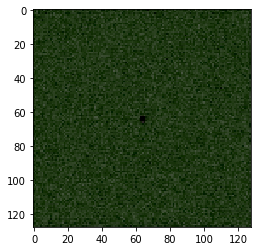

In [187]:
plt.imshow(((state_grid[0, :3, ...]).cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

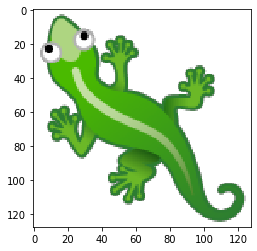

In [171]:
plt.imshow((target[0].cpu().permute(1, 2, 0).data.numpy() + 1) / 2)